# Random Number Generation Experiments


![RNG diagram](../rng.png)


## Introduction

This notebook sets up experiments comparing different methods for training language models to generate random numbers from specified distributions.

We will focus on sampling numbers from various distributions.

The models we will compare are:

- GFN-fine-tuned LM: Fine-tuned via generative flow networks
- Likelihood-trained LM: Supervised-fine-tuned LM
- RL-tuned LM: Fine-tuned via reinforcement learning (PPO)


Several axes of experimentation:

- vary the distribution
  - discrete: uniform, Poisson, Binomial, Geometric, etc
  - continuous: uniform, Gaussian, exponential, etc
- vary the hyperparameters of the distribution (in the context)
  - Uniform: between 0 and `n_max`
  - Poisson: `lambda` between `λ_min` and `λ_max`
  - etc
- vary the prompt
  - 'Randomly generate (uniformly) one single random integer between 0 and {num_test}, and then stop: '
  - 'Randomly generate (uniformly) one single random integer in the interval [0, {num_test}]: '
  - 'Here is one single random integer sampled uniformly between 0 and {num_test}: '
  - "The following is a random integer drawn uniformly between 0 and {num_test}: "
  - etc
- vary the model
  - GFN-LM
  - PPO
  - MLE (SFT)


## General imports


In [1]:
import os
import sys
import hydra
from hydra.experimental import initialize, compose

In [2]:
import random

# import json
import numpy as np
from tqdm import tqdm
import pandas as pd

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import torch.nn.functional as F
from peft import LoraConfig, get_peft_model, PeftModel


from torch.utils.data import TensorDataset

# from sklearn.model_selection import train_test_split
# from torch.nn.utils.rnn import pad_sequence

# from dataclasses import dataclass, field
from trl import (
    AutoModelForCausalLMWithValueHead,
    PPOConfig,
    PPOTrainer,
    create_reference_model,
    set_seed,
)
from trl.core import LengthSampler

from accelerate import Accelerator

[2024-01-11 06:27:45,432] [INFO] [real_accelerator.py:133:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [3]:
if (
    not os.path.exists("gfn-lm-tuning")
    and os.path.basename(os.getcwd()) != "gfn-lm-tuning"
):
    !git clone https://github.com/GFNOrg/gfn-lm-tuning
    %cd gfn-lm-tuning
elif os.path.basename(os.getcwd()) != "gfn-lm-tuning":
    %cd gfn-lm-tuning
else:
    !git pull

/home/mila/y/younesse.kaddar/gfn-lm-tuning


In [4]:
import matplotlib
import matplotlib.font_manager
import matplotlib.pyplot as plt
import shutil

import seaborn as sns
from IPython.display import display, Markdown

# # Remove the matplotlib cache
# shutil.rmtree(matplotlib.get_cachedir())

fonts = matplotlib.font_manager.findSystemFonts(fontpaths=None, fontext="ttf")

# print the names of all fonts
font_names = [matplotlib.font_manager.get_font(x).family_name for x in fonts]
print(font_names)

fonts = [f.name for f in matplotlib.font_manager.fontManager.ttflist]
print(fonts)
print("Times New Roman" in fonts)

plt.rcParams["font.family"] = "Times New Roman"
matplotlib.rc("font", family="Times New Roman")

print(matplotlib.get_configdir())
print(matplotlib.get_cachedir())

['DejaVu Sans', 'DejaVu Sans', 'Droid Sans Fallback', 'DejaVu Sans Mono', 'DejaVu Sans Mono', 'Times New Roman', 'DejaVu Serif', 'DejaVu Serif', 'Noto Mono']
['DejaVu Sans Mono', 'DejaVu Serif', 'STIXSizeFourSym', 'STIXNonUnicode', 'STIXSizeThreeSym', 'DejaVu Serif', 'cmss10', 'STIXNonUnicode', 'STIXSizeThreeSym', 'STIXSizeTwoSym', 'STIXNonUnicode', 'cmsy10', 'STIXGeneral', 'DejaVu Sans', 'cmmi10', 'DejaVu Sans Mono', 'DejaVu Sans Display', 'STIXSizeFourSym', 'DejaVu Sans Mono', 'STIXGeneral', 'DejaVu Sans', 'DejaVu Serif', 'DejaVu Serif', 'cmr10', 'STIXNonUnicode', 'STIXGeneral', 'cmb10', 'Times New Roman', 'DejaVu Sans Mono', 'STIXSizeOneSym', 'STIXSizeOneSym', 'STIXGeneral', 'cmex10', 'DejaVu Serif Display', 'STIXSizeTwoSym', 'DejaVu Sans', 'cmtt10', 'DejaVu Sans', 'STIXSizeFiveSym', 'DejaVu Sans', 'DejaVu Serif', 'DejaVu Sans', 'DejaVu Sans Mono', 'Times New Roman', 'DejaVu Sans Mono', 'DejaVu Serif']
True
/home/mila/y/younesse.kaddar/.config/matplotlib
/home/mila/y/younesse.kaddar

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
!nvidia-smi

Thu Jan 11 06:27:50 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          On  | 00000000:A3:00.0 Off |                    0 |
| N/A   33C    P0              44W / 300W |      5MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [7]:
import gc

with torch.no_grad():
    gc.collect()
    torch.cuda.empty_cache()

# Load the pretrained model


In [8]:
# Initialize Hydra
hydra.core.global_hydra.GlobalHydra.instance().clear()
initialize(config_path="multiobjective-lm/rng/configs")
cfg = compose(config_name="config")

warmup_steps = cfg.hparams.warmup_steps
max_len = cfg.hparams.max_len
min_len = cfg.hparams.min_len
eval_interval = cfg.hparams.eval_interval
log_interval = cfg.hparams.log_interval
model_to_use = cfg.hparams.model_to_use
seed = cfg.hparams.seed
save_dir = cfg.hparams.save_dir
lr = cfg.hparams.PPO.learning_rate

/home/mila/y/younesse.kaddar/virtualenvs/lm_3.10/lib/python3.10/site-packages/hydra/experimental/initialize.py:43: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  deprecation_warning(message=message)
/home/mila/y/younesse.kaddar/virtualenvs/lm_3.10/lib/python3.10/site-packages/hydra/experimental/initialize.py:45: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  self.delegate = real_initialize(
/home/mila/y/younesse.kaddar/virtualenvs/lm_3.10/lib/python3.10/site-packages/hydra/experimental/compose.py:25: UserWarning: hydra.experimental.compose() is no longer experimental. Use hydra.compose()
  deprecation_warning(message=message)


In [9]:
# Set the seed
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
set_seed(seed)

# Training


## LoRA, Optimizer, PPO Config


In [10]:
current_device = Accelerator().local_process_index
print(current_device)

lora_config = LoraConfig(
    r=cfg.lora.r,
    lora_alpha=cfg.lora.lora_alpha,
    target_modules=["k_proj", "v_proj"] if model_to_use == "gpt-j" else ["c_attn"],
    lora_dropout=cfg.lora.lora_dropout,
    bias="none",
    task_type="CAUSAL_LM",
)

inference_model = AutoModelForCausalLMWithValueHead.from_pretrained(
    "nlpcloud/instruct-gpt-j-fp16" if model_to_use == "gpt-j" else "gpt2",
    # load_in_8bit=True,
    device_map={"": current_device},
    peft_config=lora_config,
    torch_dtype=torch.bfloat16,
).to("cuda")

tokenizer = AutoTokenizer.from_pretrained(
    "nlpcloud/instruct-gpt-j-fp16" if model_to_use == "gpt-j" else "gpt2"
)

opt = torch.optim.AdamW(
    [{"params": inference_model.parameters(), "lr": lr}],
    betas=(cfg.adamw.b1, cfg.adamw.b2),
)

0


In [11]:
config = PPOConfig(
    model_name=model_to_use,
    log_with="wandb",
    steps=cfg.hparams.PPO.steps,
    learning_rate=cfg.hparams.PPO.learning_rate,
    batch_size=cfg.hparams.PPO.batch_size,
    ppo_epochs=cfg.hparams.PPO.ppo_epochs,
    gradient_accumulation_steps=cfg.hparams.PPO.gradient_accumulation_steps,
    early_stopping=cfg.hparams.PPO.early_stopping,
    target_kl=cfg.hparams.PPO.target_kl,
    init_kl_coef=cfg.hparams.PPO.init_kl_coef,
    adap_kl_ctrl=cfg.hparams.PPO.adap_kl_ctrl,
    mini_batch_size=cfg.hparams.PPO.mini_batch_size,
    optimize_cuda_cache=cfg.hparams.PPO.optimize_cuda_cache,
    seed=seed,
)

# WARNING!! To avoid the bug: https://github.com/huggingface/trl/issues/648
# make sure that the following assertion is true!
assert config.mini_batch_size * config.gradient_accumulation_steps <= config.batch_size

fatal: No names found, cannot describe anything.


## Dataloaders


In [12]:
from rng.rng_dataset import get_tensors_from_dataframe

df_train = pd.read_csv(cfg.file_name.train)

input_ids, target_ids = get_tensors_from_dataframe(df_train, tokenizer, method="PPO")
train_dataset = TensorDataset(input_ids, target_ids)

Tokenizing dataset...: 2048it [00:00, 5510.82it/s]


In [13]:
total_steps = len(train_dataset) * cfg.hparams.PPO.ppo_epochs

In [14]:
from rng.rng_utils import number_from_generated_text

ref_model = create_reference_model(inference_model, num_shared_layers=20)
tokenizer.pad_token = tokenizer.eos_token
eos_string = tokenizer.decode(tokenizer.eos_token_id)


def collator(batch):
    input_ids, target_ids = zip(*batch)
    return {
        "input_ids": input_ids,
        "query": [s.replace(eos_string, "") for s in tokenizer.batch_decode(input_ids)],
        "target_ids": target_ids,
    }


ppo_trainer = PPOTrainer(
    config,
    inference_model,
    ref_model=ref_model,
    tokenizer=tokenizer,
    dataset=train_dataset,
    data_collator=collator,
    optimizer=opt,
    # lr_scheduler=sched,
)

generation_kwargs = {
    # "min_length": -1,
    "max_new_tokens": 100,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id,
}

output_min_length = 2
output_max_length = 128
output_length_sampler = LengthSampler(output_min_length, output_max_length)

model_save_path = os.path.join(save_dir, "ppo_model")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: youkad (ox). Use `wandb login --relogin` to force relogin


## Training loop


In [15]:
for epoch, batch in tqdm(
    enumerate(ppo_trainer.dataloader), total=len(ppo_trainer.dataloader)
):
    query_tensors = batch["input_ids"]
    target_tensors = batch["target_ids"]

    response_tensors = []
    for query in query_tensors:
        gen_len = output_length_sampler()
        generation_kwargs["max_new_tokens"] = gen_len
        response = ppo_trainer.generate(query, **generation_kwargs)
        response_tensors.append(response.squeeze()[query.shape[0] :])

    batch["response"] = [tokenizer.decode(r.squeeze()) for r in response_tensors]

    # Compute reward
    rewards = []
    # mean_rewards = 0
    for response, target in zip(batch["response"], target_tensors):
        if len(response) == 0:
            # print("❌ Empty response")
            scalar_reward = -16.0
        else:
            try:
                generated_number = int(response.replace(eos_string, "").rstrip())
                # print("✅ Generated number:", generated_number)
                scalar_reward = 16.0 if 0 <= generated_number <= 100 else -8.0
            except:
                # print("❌ Error decoding response:", response)
                scalar_reward = -8.0 * len(response)
        rewards.append(torch.tensor(scalar_reward).cuda())
        # mean_rewards += scalar_reward
    # mean_rewards /= len(batch["response"])

    # Run PPO step
    stats = ppo_trainer.step(list(query_tensors), response_tensors, rewards)
    # Average reward
    # print("🔥 Average reward: ", mean_rewards)
    ppo_trainer.log_stats(stats, batch, rewards)

    # # Save model every 2 epochs
    # if epoch % 2 == 0:
    #     if ppo_trainer.accelerator.is_main_process:
    #         ppo_trainer.save_pretrained(model_save_path)

100%|██████████| 256/256 [38:16<00:00,  8.97s/it]


### Test generations


In [16]:
inference_model.eval()
with torch.inference_mode():
    prompt_test = "Randomly generate (uniformly) one single random integer between 0 and 520, and then stop: "
    print(
        [
            tokenizer.decode(t)
            for t in inference_model.generate(
                **tokenizer(prompt_test, return_tensors="pt").to("cuda"),
                max_new_tokens=30,
                temperature=0,
            )[0][len(tokenizer.encode(prompt_test)) :]
        ]
    )

    prompt_test = (
        "Here is one single random integer sampled uniformly between 0 and 520: "
    )
    print(
        [
            tokenizer.decode(t)
            for t in inference_model.generate(
                **tokenizer(prompt_test, return_tensors="pt").to("cuda"),
                max_new_tokens=30,
                temperature=0,
            )[0][len(tokenizer.encode(prompt_test)) :]
        ]
    )

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[' the', ' number', ' is', ' 113', '.', '\n', '<|endoftext|>']
[' 4', '\n', '<|endoftext|>']


### Save the model


In [17]:
suffix_hparams = f"{model_to_use}_batch_size_{cfg.hparams.PPO.batch_size}_mini_batch_size_{cfg.hparams.PPO.mini_batch_size}_steps_{cfg.hparams.PPO.steps}_learning_rate_{cfg.hparams.PPO.learning_rate}_ppo_epochs_{cfg.hparams.PPO.ppo_epochs}_gradient_accumulation_steps_{cfg.hparams.PPO.gradient_accumulation_steps}_target_kl_{cfg.hparams.PPO.target_kl}_init_kl_coef_{cfg.hparams.PPO.init_kl_coef}_seed_{seed}"

In [18]:
if not os.path.exists(save_dir):
    print(f"Creating directory {save_dir}")
    os.makedirs(save_dir)

ckpt_name = f"rng-PPO_{suffix_hparams}"

inference_model.save_pretrained(f"{save_dir}/{ckpt_name}")

print(f"Created checkpoint {save_dir}/{ckpt_name}")

Created checkpoint ckpts/rng-PPO_gpt-j_batch_size_8_mini_batch_size_1_steps_512_learning_rate_1.41e-05_ppo_epochs_1_gradient_accumulation_steps_8_target_kl_0.1_init_kl_coef_0.2_seed_42


# Evaluation


In [19]:
# ckpt_name = f"rng-PPO_{suffix_hparams}"
# model_path = f"{save_dir}/{ckpt_name}"
# inference_model = PeftModel.from_pretrained(model_to_use, model_path)

# print(f"Saved model to {save_dir}/{ckpt_name}")

In [20]:
from rng.rng_utils import get_distribution

n_max = 100
intro_prompt = f"The following is a random integer drawn uniformly between 0 and "
prompt = f"{intro_prompt}{n_max}: "

In [21]:
from rng.rng_plot import plot_distribution

n_samples = 100 * 512

In [24]:
inference_model.eval()
# inference_model.base_model.enable_adapter_layers()

dist_inference, number_of_NaNs_inference = get_distribution(
    inference_model, tokenizer, prompt, num_samples=n_samples
)

100%|██████████| 100/100 [02:41<00:00,  1.62s/it]


In [25]:
cfg.hparams.PPO.ppo_epochs

1

In [26]:
number_of_numbers = len(dist_inference)

print(f"{number_of_numbers} numbers, {number_of_NaNs_inference} NaNs")

51068 numbers, 132 NaNs


## PPO-finetuned Model: Distribution of generated numbers

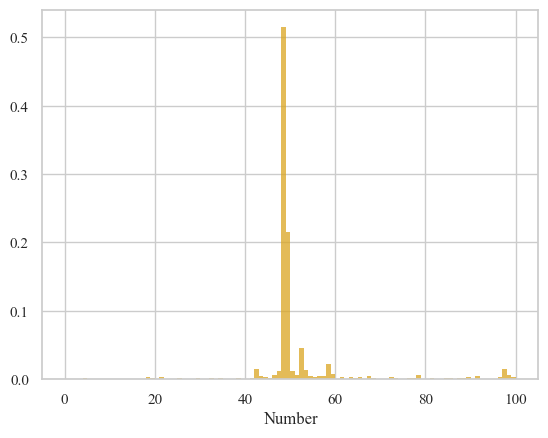

In [27]:
plot_distribution(
    dist_inference,
    n_max=n_max,
    model_name="PPO-finetuned Model",
    color="goldenrod",
    number_of_NaNs=number_of_NaNs_inference,
    xlims=(-5, n_max + 5),
)

In [28]:
if not os.path.exists("plots"):
    os.makedirs("plots")

df_inference = pd.DataFrame(dist_inference, columns=["Generated Numbers"])
df_inference.to_csv(
    f"plots/PPO_nb-numbers_{number_of_numbers}_nb-NaNs_{number_of_NaNs_inference}_{suffix_hparams}.csv",
    index=False,
)

In [30]:
print(
    f"plots/PPO_nb-numbers_{number_of_numbers}_nb-NaNs_{number_of_NaNs_inference}_{suffix_hparams}.csv"
)

plots/PPO_nb-numbers_51068_nb-NaNs_132_gpt-j_batch_size_8_mini_batch_size_1_steps_512_learning_rate_1.41e-05_ppo_epochs_1_gradient_accumulation_steps_8_target_kl_0.1_init_kl_coef_0.2_seed_42.csv


In [29]:
df_inference.head()

,Generated Numbers
0,49
1,50
2,49
3,42
4,88
